In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## 读入图像并转为单通道

(720, 1280, 3)


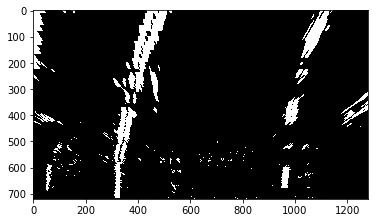

In [2]:
binary_warped = cv2.imread('binary_road.jpg')
plt.imshow(binary_warped)
print(binary_warped.shape)

In [3]:
binary_gray = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
print(binary_gray.shape)

(720, 1280)


## 根据直方图峰值确定车道线

In [4]:
histogram = np.sum(binary_gray[binary_gray.shape[0]//2:,:], axis = 0)
print(type(histogram))

<class 'numpy.ndarray'>


In [5]:
print(histogram.shape)

(1280,)


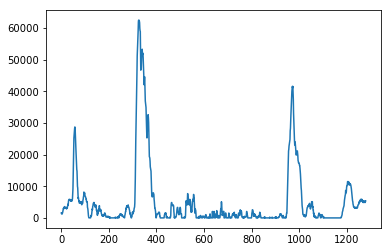

In [6]:
plt.plot(histogram)

In [7]:
midpoint = np.int(histogram.shape[0]//2)
print(type(midpoint))
print(midpoint)

<class 'int'>
640


In [12]:
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base)
print(rightx_base)

327
971


In [13]:
nwindows = 9
window_height = np.int(binary_gray.shape[0]//nwindows)
nonzero = binary_gray.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
print(len(nonzero))

2


In [14]:
print(type(nonzerox))
print(nonzerox.shape)
print(nonzerox[:1000])

<class 'numpy.ndarray'>
(89486,)
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   44   46  106  109  110  111  112  113  114  115  116  117  118
  119  120  121  122  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  161  164  167  433  434  435  436  437  438  439
  440  441  442  443  444  445  446  447  448  449  450  451  452  453
  454  455  456  457  458  459  460  461  462  463  464  465  466  467
  468  469  470  471  472  473  474  475  477  479  482  483  484  485
  486  487  488  489  490  491  492  493  494  495  496  497  498  499
  500  501  502  503  504  505  506  507  508  509  510  511  512  513
  515  516  518  519  520  521  522  523  524  525  526  527  528  529
  530  533 1090 1091 1093 1095 1097 1098 1099 1100 1101 1102 1103 1104
 1105 1106 1107 1108 1109 1111 1112 1116 111

In [15]:
leftx_current = leftx_base
rightx_current = rightx_base

In [16]:
margin = 100
minpix = 50
left_lane_inds = []
right_lane_inds = []

In [17]:
for window in range(nwindows):
    win_y_low = binary_gray.shape[0] - (window+1)*window_height
    win_y_high = binary_gray.shape[0] - window*window_height
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    cv2.rectangle(binary_warped,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2)
    cv2.rectangle(binary_warped,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2)
    
    #这一步让我感到很困惑
    good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox >= win_xleft_low) &
                      (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

In [18]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

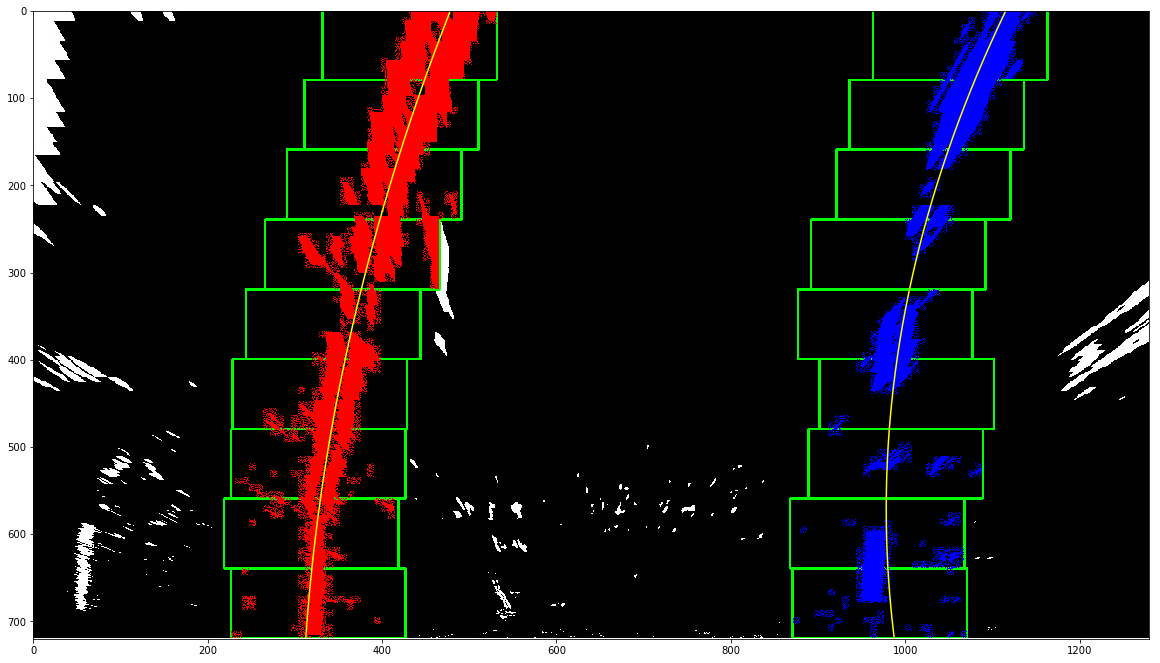

In [19]:
ploty = np.linspace(0, binary_gray.shape[0]-1, binary_gray.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

binary_warped[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
binary_warped[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(20,14))
plt.imshow(binary_warped)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [20]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_gray.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

[[[375.91293414   0.        ]
  [375.56608014   1.        ]
  [375.21954026   2.        ]
  ...
  [575.21954026   2.        ]
  [575.56608014   1.        ]
  [575.91293414   0.        ]]]
[[[1.01592368e+03 0.00000000e+00]
  [1.01543531e+03 1.00000000e+00]
  [1.01494782e+03 2.00000000e+00]
  ...
  [1.21494782e+03 2.00000000e+00]
  [1.21543531e+03 1.00000000e+00]
  [1.21592368e+03 0.00000000e+00]]]


(720, 0)

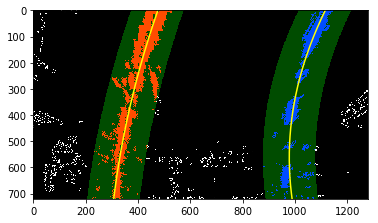

In [21]:
out_img = np.dstack((binary_gray, binary_gray, binary_gray))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
print(left_line_pts)
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))
print(right_line_pts)

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [23]:
print(left_line_window1.shape)
left_line_window1

(1, 720, 2)


array([[[375.91293414,   0.        ],
        [375.56608014,   1.        ],
        [375.21954026,   2.        ],
        ...,
        [207.84610156, 717.        ],
        [207.724464  , 718.        ],
        [207.60314054, 719.        ]]])

In [26]:
print(left_line_window2.shape)
left_line_window2

(1, 720, 2)


array([[[407.60314054, 719.        ],
        [407.724464  , 718.        ],
        [407.84610156, 717.        ],
        ...,
        [575.21954026,   2.        ],
        [575.56608014,   1.        ],
        [575.91293414,   0.        ]]])

In [27]:
left_line_pts.shape

(1, 1440, 2)

In [30]:
print(left_line_pts[:,715:725,:])

[[[208.09031901 715.        ]
  [207.96805323 716.        ]
  [207.84610156 717.        ]
  [207.724464   718.        ]
  [207.60314054 719.        ]
  [407.60314054 719.        ]
  [407.724464   718.        ]
  [407.84610156 717.        ]
  [407.96805323 716.        ]
  [408.09031901 715.        ]]]
